# Neural Networks Brain Surgery: Visualization of Financial Models
<div style="text-align: right">(C) Nikolai Nowaczyk, Jörg Kienitz, Sarp Kaya Acar, Qian Liang 2020</div>

Natural neural networks in the brains of financial engineers regard some financial models as more complex than others. For example, the Heston stochastic volatility model is regarded as more sophisticated than the plain-vanilla Black-Scholes model. But as how different do these model look like for an artificial neural network? We explore this question by training a neural network for each model under a comparable parameter set, compare their learning curves and visualize their trainable weights. We find that from a machine learning perspective, these models are actually not that different.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, LSTM
import keras
import os
from ipywidgets import interact
import ipywidgets as wg
import json
import pickle
import unittest

from keras_grid import MLPGrid, LSTMGrid
from pricinglib import BlackScholesCallPrice, HestonCallPrice

%matplotlib notebook

# The Financial Models

## Black-Scholes Model

Let $(\Omega, \mathcal{F}, \mathbb{Q})$ be a probability space (where we think of $\mathbb{Q}$ as the risk-neutral measure). Then the Black-Scholes model assumes the following stochastic dynamics for the stock:
\begin{align}
dS_t = r S_t dt + \sigma S_t dW_t, \qquad S_0 = s_0
\end{align}
where
* $s_0$ is the initial value for the stock
* $r \in \mathbb{R}$ is a fixed *risk-free rate*, 
* $\sigma > 0$ is the *volatility*, 
and the process $W_t$ is a Brownian motion. 

In the Black-Scholes model, a European call option $C = C(T,K)$ with maturity $T>0$ and strike $K>0$ has market value 
\begin{align}
    C_t = \mathbb{E}_t[(S_T - K)^+] = S_t \Phi(d_1) - K \exp(-r (T-t)) \Phi(d_2),
\end{align}
where $\Phi$ denotes the cdf of the standard normal distribution and 
$$ d_1 := \frac{1}{\sqrt{T-t}} \Big( \log\Big( \frac{S_t}{K} \Big) + (r + \frac{\sigma^2}{2}) (t-T) \Big), \quad
d_2 := d_1 - \sigma \sqrt{T-t}$$

## Heston Model
The Heston model assumes the following stochastic dynamics:
\begin{align}
    dS_t &= rS_t dt + \sqrt(V_t)dW_t, \quad S_0 = s_0 \\
    dV_t &= \kappa(\theta - V_t) S_t dt + \xi \sqrt{V_t} dZ_t, && V_0 = v_0,
\end{align}
where
* $s_0$ is the initial value for the stock,
* $v_0$ is the initial value for the volatility,
* $r$ is the risk-free rate,
* $\kappa$ is the mean reversion rate of the volatility,
* $\xi$ is the volatility of the volatility
* $\rho$ is the assumed correlation between the Brownian motions $W_t$ and $Z_t$.

One typically assumes that the parameters are chosen such that the Feller condition holds: $2 \kappa \theta > \xi^2$.

The option price in a Heston model can be computed (for $t=0$) via 
\begin{align}
    C_0(T,K) = S_0 + \Pi_1 - e^{-rT} K \Pi_2,
\end{align}
where $\Pi_1$ and $\Pi_2$ are given as integrals over the characteristic function $\Psi = \Psi_{\ln(S_T)}$ of $\ln(S_T)$:
\begin{align}
    \Pi_1 &= \frac{1}{2} + \frac{1}{\pi}\int_0^{\infty}{\operatorname{Re}\Big( \frac{e^{-iw \ln(K)} \Psi(w-i)}{i w \Psi(-i)} \Big) dw} \\
    \Pi_2 &= \frac{1}{2} + \frac{1}{\pi} \int_0^{\infty}{\operatorname{Re}\Big( \frac{e^{-iw \ln(K)} \Psi(w)}{i w } \Big) dw}
\end{align}

## Observations

**1. Parameters:** The number of parameters is a key difference between these models, which is important for humans and machines alike. The Heston models has more parameters than the Black/Scholes model and it is clear that a network, wich has to learn the dependence of the option price on all of the Heston parameters needs to be set up differently than for Black-Scholes. Therefore, we restrict our attention only to learning the pricing function on a fixed grid of strikes and maturities $(K,T)$ with the other model parameters being fixed.

**2. Pricing Formula:** Even with fixed parameters, the option pricing formula in the Heston model is undoubtedly more difficult for humans as it involves solving indefinite integrals of complex functions. 

# Generating the Data Set

In [3]:
# parameter configuration
S0=100
T_max=1
maturity_grid = np.linspace(1/300, T_max, 300)
strike_grid = np.linspace(S0*0.8, S0*1.2, 400)
maturity_grid_, strike_grid_ = np.meshgrid(maturity_grid, strike_grid)
maturity_grid_ = maturity_grid_.ravel()
strike_grid_ = strike_grid_.ravel()

# heston model
v0 = 0.02
vLong = 0.04
kappa = 0.3
volvol = 0.4
rho = -0.6
q=0

# black scholes model
S = 100  # spot price
r = 0  # risk-free rate
sigma = np.sqrt(v0) # volatility

In [5]:
# generation of the data set
data_folder = os.path.join(os.getcwd(), 'data_surgery')
filename = 'df_prices_surgery.pkl'

In [4]:
df = pd.DataFrame({'K': strike_grid_,
                   'T': maturity_grid_,
                   'C_BlackScholes': BlackScholesCallPrice(S0, r, sigma, maturity_grid_, strike_grid_, t=0)})
df['C_Heston'] = df.apply(lambda row: HestonCallPrice(S0, row['T'], row['K'], r, q, v0, vLong, kappa, sigma, rho), axis=1)
df.to_pickle(os.path.join(data_folder, filename)) # save dataset to file

In [6]:
df = pd.read_pickle(os.path.join(data_folder, filename)) # load dataset from file

## Visualizing the Data Set

<IPython.core.display.Javascript object>


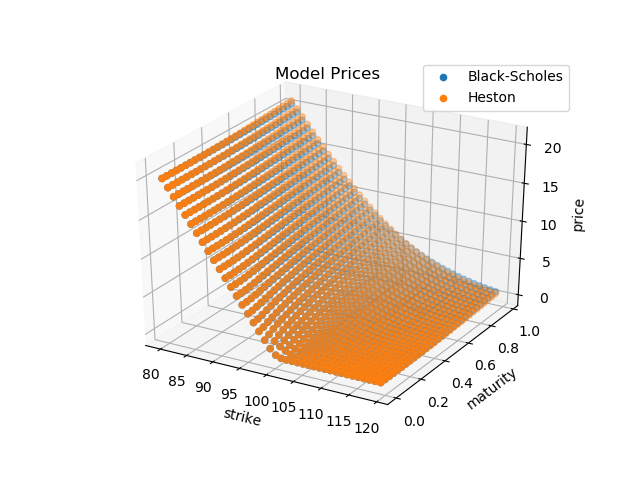

interactive(children=(SelectMultiple(description='Models', index=(0, 1), options=('BlackScholes', 'Heston'), v…

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# thinning out the df to avoid performance issues in the plot
df_3dplot = df[(df['T'].isin(maturity_grid[::10])) & (df['K'].isin(strike_grid[::10]))]

@interact(models=wg.SelectMultiple(
    options=['BlackScholes', 'Heston'],
    value=['BlackScholes', 'Heston'],
    description='Models',
))
def plot_dataset(models):
    ax.clear()
    if 'BlackScholes' in models:
        ax.scatter3D(df_3dplot['K'], df_3dplot['T'], df_3dplot['C_BlackScholes'], label='Black-Scholes')
    if 'Heston' in models:
        ax.scatter3D(df_3dplot['K'], df_3dplot['T'], df_3dplot['C_Heston'], label='Heston')
    ax.legend()
    ax.set_xlabel('strike')
    ax.set_ylabel('maturity')
    ax.set_zlabel('price')
    ax.set_title('Model Prices')

## Observation
While from a human point of view, computing prices in a Heston model is considerably more difficult than in the Black-Scholes model, the resulting data sets are structurally quite similar. 

# Setting up the Neural Networks

In [8]:
model_names = ['BlackScholes', 'Heston']
num_units = 128
np.random.seed(1)
models = {m: Sequential([Dense(units=num_units, input_shape=(2,), activation='sigmoid'),
                         Dense(units=num_units, input_shape=(2,), activation='sigmoid'),
                                Dense(units=1, activation='linear')]) for m in model_names}

## Training

In [9]:
compile_params = {
    'loss': 'mean_squared_error',
    'metrics': ['mean_squared_error', 'mean_absolute_error'],
    'optimizer': 'Adam',
}

for m in model_names:
    models[m].compile(**compile_params)

In [10]:
grid_spacing = 10
grid_offset = 5

df_train = df[(df['T'].isin(maturity_grid[::grid_spacing])) & (df['K'].isin(strike_grid[::grid_spacing]))]
df_cv = df[(df['T'].isin(maturity_grid[grid_offset::grid_spacing])) & (df['K'].isin(strike_grid[grid_offset::grid_spacing]))]

fit_params={
    'x': df_train[['K', 'T']],
    'epochs': 500,
    'shuffle': True}

In [ ]:
history = {}
for m in model_names:
    history[m] = models[m].fit(y=df_train['C_' + m], 
                               validation_data=(df_cv[['K', 'T']], df_cv['C_' + m]), **fit_params)

## Learning Curves

<IPython.core.display.Javascript object>


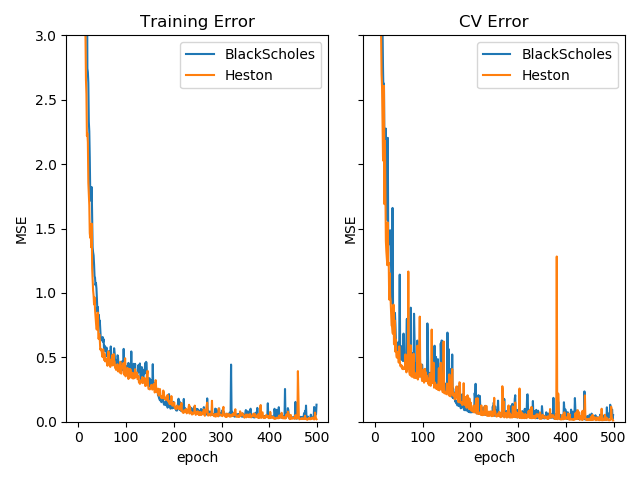

In [21]:
fig, axes = plt.subplots(1,2, sharex=True, sharey=True)

axes[0].set_title('Training Error')
for i in range(2):
    axes[0].plot(history[model_names[i]].history['loss'], label=model_names[i])

axes[1].set_title('CV Error')
for i in range(2):
    axes[1].plot(history[model_names[i]].history['val_mean_squared_error'], label=model_names[i])

for i in range(2):
    axes[i].set_ylim([0,3])
    axes[i].set_xlabel('epoch')
    axes[i].set_ylabel('MSE')
    axes[i].legend(loc='upper right')
plt.tight_layout()

## Observation
The increased complexity of the Heston model does not make it more difficult for the network to learn the pricing function.

# Evaluating Neural Network Performance

In [14]:
for m in model_names:
    print(models[m].evaluate(x=df[['K', 'T']], y=df['C_' + m]))

120000/120000 [==============================] - 2s 17us/step
[0.05176283833984053, 0.05176283833984053, 0.1901557292987903]
120000/120000 [==============================] - 2s 18us/step
[0.010538777064573788, 0.010538777064573788, 0.06757473641782999]


In [15]:
res = {m : models[m].predict(df[['K', 'T']].values.astype(np.float32))[:,0] - df['C_' + m].values for m in model_names}

<IPython.core.display.Javascript object>


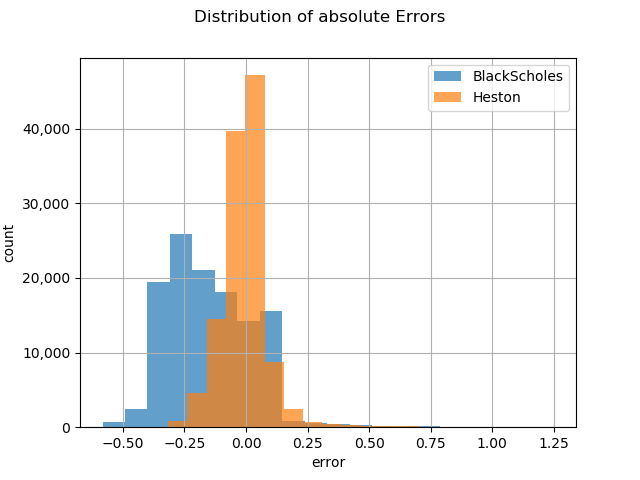

In [23]:
fig, ax = plt.subplots()

fig.suptitle('Distribution of absolute Errors')
for m in model_names:
    pd.Series(res[m]).hist(bins=20, label=m, alpha=0.7)
ax.legend()
ax.set_xlabel('error')
ax.set_ylabel('count')
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

**Observation:** The distribution of the absolute error over the entire data set (includes training, cross-validation is similar between the models.

# Brain Surgery
We plot the trained weights in the neural network from the Black-Scholes and the Heston model.

<IPython.core.display.Javascript object>


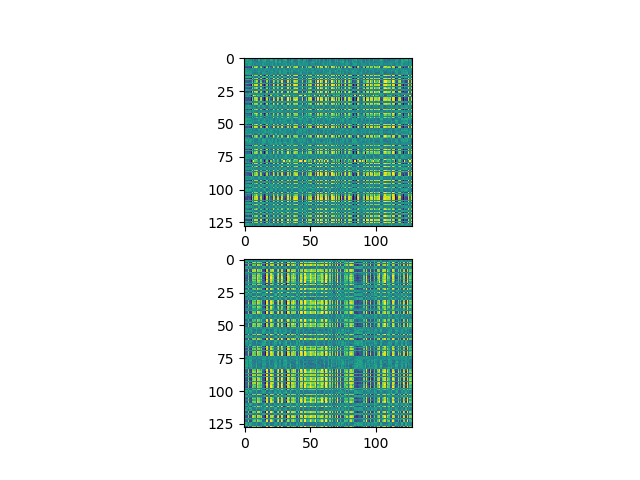

interactive(children=(IntSlider(value=0, description='layer_index', max=2), Dropdown(description='Weight Type:…

In [20]:
fig, ax = plt.subplots(2)
@interact(layer_index=wg.IntSlider(min=0, max=2, value=0),
          weight_type=wg.Dropdown(options=[('W',0), ('b',1)], value=0, description='Weight Type:'),
          vmin=wg.IntSlider(min=-10, max=-1, value=-5),
          vmax=wg.IntSlider(min=1, max=10, value=5))
def plot_weights_image(layer_index, weight_type, vmin, vmax):
    bs = models[model_names[0]].layers[layer_index].get_weights()[weight_type]
    heston = models[model_names[1]].layers[layer_index].get_weights()[weight_type]
    if weight_type==1:
        bs = bs[np.newaxis, :]
        heston = heston[np.newaxis, :]
    ax[0].imshow(bs, vmin=vmin, vmax=vmax)
    ax[1].imshow(heston, vmin=vmin, vmax=vmax)

<IPython.core.display.Javascript object>


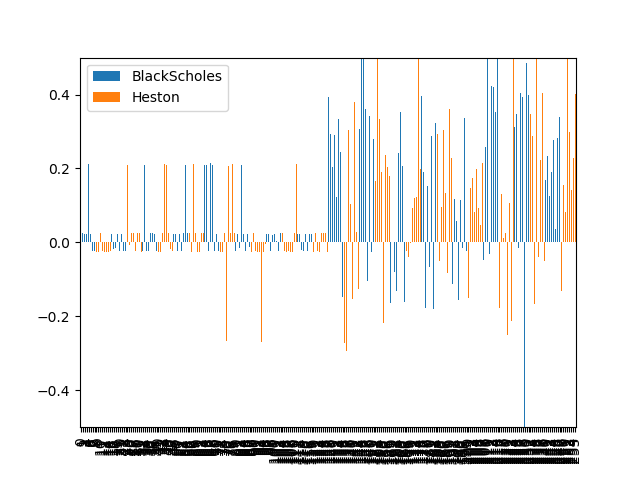

interactive(children=(IntSlider(value=0, description='layer_index', max=3), Dropdown(description='Weight Type:…

In [19]:
fig, ax = plt.subplots()

@interact(layer_index=wg.IntSlider(min=0, max=3, value=0),
          weight_type=wg.Dropdown(options=[('W', 0), ('b', 1)], value=0, description='Weight Type:'))
def plot_weights(layer_index, weight_type):
    ax.clear()    
    pd.DataFrame({model_names[0]: models[model_names[0]].layers[layer_index].get_weights()[weight_type].flatten(),
                  model_names[1]: models[model_names[1]].layers[layer_index].get_weights()[weight_type].flatten()}).plot.bar(ax=ax)
    ax.set_ylim([-0.5, 0.5])